IMAGE CLASSIFICATION

How to classify images of flowers using a tf.keras.Sequential model and load data using tf.keras.utils.image_dataset_from_directory. It demonstrates the following concepts:

Efficiently loading a dataset off disk.
Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.
workflow:

Examine and understand data
Build an input pipeline
Build the model
Train the model
Test the model
Improve the model and repeat the process

SET UP 

IMPORT NECESSARIES LIBRARIES 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

LOAD THE DATASET 

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/

In [2]:
import pathlib

# URL of dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

# Download + auto-extract the dataset
data_dir = tf.keras.utils.get_file(
    fname="flower_photos",
    origin=dataset_url,
    untar=True
)

# Convert to pathlib path
data_dir = pathlib.Path(data_dir)

print("Extracted to:", data_dir)




228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step
Extracted to: C:\Users\AASTHA\.keras\datasets\flower_photos


In [ ]:
data_dir = data_dir / "flower_photos"
print(data_dir)

C:\Users\AASTHA\.keras\datasets\flower_photos\flower_photos


In [ ]:
image_count = len(list(data_dir.glob("*/*.jpg")))
print(image_count)

3670


Upload the .tgz file:

from google.colab import files

uploaded = files.upload()

Extract the .tgz file:

import tarfile file_path = "/content/myfile.tgz"

with tarfile.open(file_path, "r:gz") as tar: tar.extractall(path="/content/")

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


3670


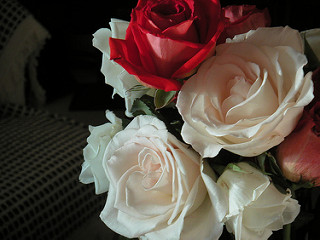

In [8]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

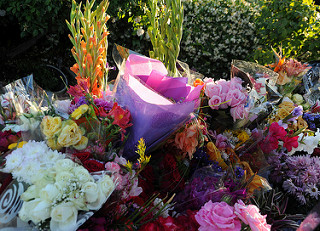

In [9]:
PIL.Image.open(str(roses[3]))

ADD SOME TUPLIS

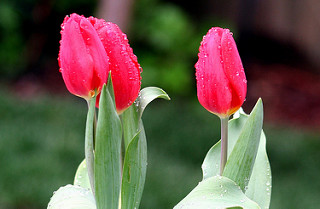

In [10]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

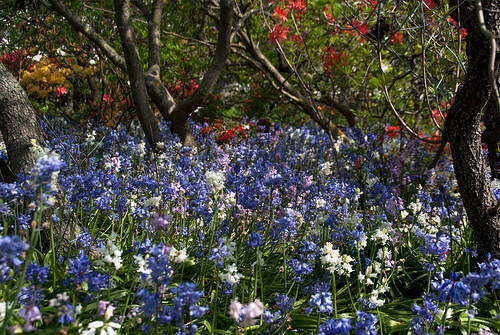

In [11]:
PIL.Image.open(str(tulips[1]))

LOAD DATASET USING KERAS UTILITIES 

Next, load these images off disk using the helpful tf.keras.utils.image_dataset_from_directory utility. This will take you from a directory of images on disk to a tf.data.Dataset in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the Load and preprocess images tutorial.

CREATE DATASET 

In [12]:
batch_size = 32
img_height = 180
img_width = 180

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [16]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


VISULIZE THE DATA 

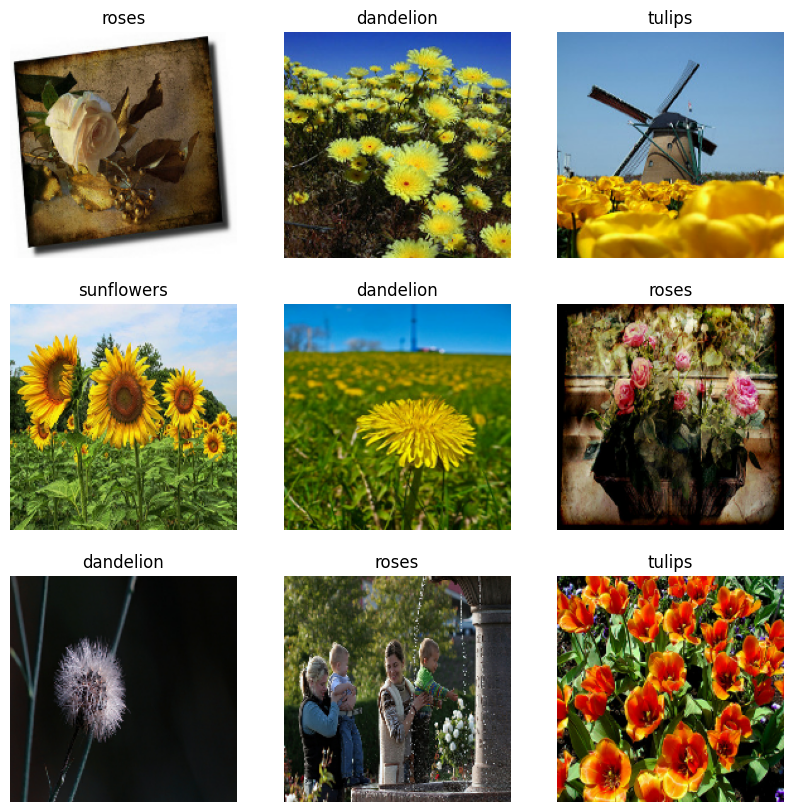

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras Model.fit method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray.

Configure the dataset for performance
Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
Dataset.prefetch overlaps data preprocessing and model execution while training.
Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [20]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling Dataset.map:

In [21]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

Note: You previously resized images using the image_size argument of tf.keras.utils.image_dataset_from_directory. If you want to include the resizing logic in your model as well, you can use the tf.keras.layers.Resizing layer.

A basic Keras model
Create the model
The Keras Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [22]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

c:\Users\AASTHA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Compile the model
For this tutorial, choose the tf.keras.optimizers.Adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

optimizer='adam' means the Adam optimizer will be used to minimize the loss function during training.

Sparse Categorical Crossentropy is commonly used for multi-class classification problems where the labels are integers (i.e., each class is represented by a single integer, not one-hot encoded).

Model summary
View all the layers of the network using the Keras Model.summary method:

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

TRAIN THE MODEL 

In [26]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 264ms/step - accuracy: 0.9905 - loss: 0.0339 - val_accuracy: 0.6308 - val_loss: 1.9039
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 280ms/step - accuracy: 0.9956 - loss: 0.0211 - val_accuracy: 0.6417 - val_loss: 2.0729
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 167ms/step - accuracy: 0.9928 - loss: 0.0232 - val_accuracy: 0.6512 - val_loss: 1.8543
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 0.9993 - loss: 0.0094 - val_accuracy: 0.6390 - val_loss: 2.4700
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.9881 - loss: 0.0405 - val_accuracy: 0.6022 - val_loss: 2.4974
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.9779 - loss: 0.0706 - val_accuracy: 0.6267 - val_loss: 2.1746
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.9942 - loss: 0.0197 - val_accuracy: 0.6267 - val_loss: 2.2976
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.9888 - loss: 0.0327 - val_accu

VISULIZE THE TRAINIG RESULT 

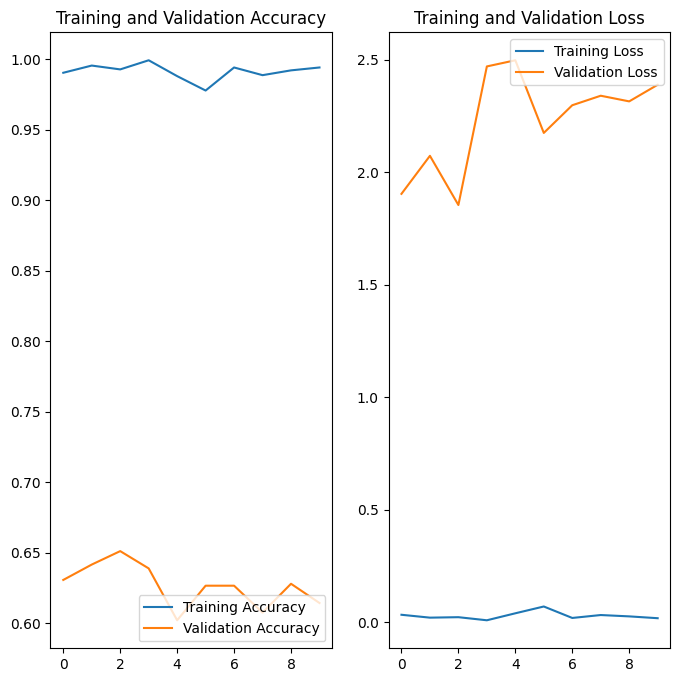

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.

OVERFITTING 

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add dropout to your model.

DATA AUGMENTATION

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: tf.keras.layers.RandomFlip, tf.keras.layers.RandomRotation, and tf.keras.layers.RandomZoom. These can be included inside your model like other layers, and run on the GPU.

In [28]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

c:\Users\AASTHA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Visualize a few augmented examples by applying data augmentation to the same image several times:

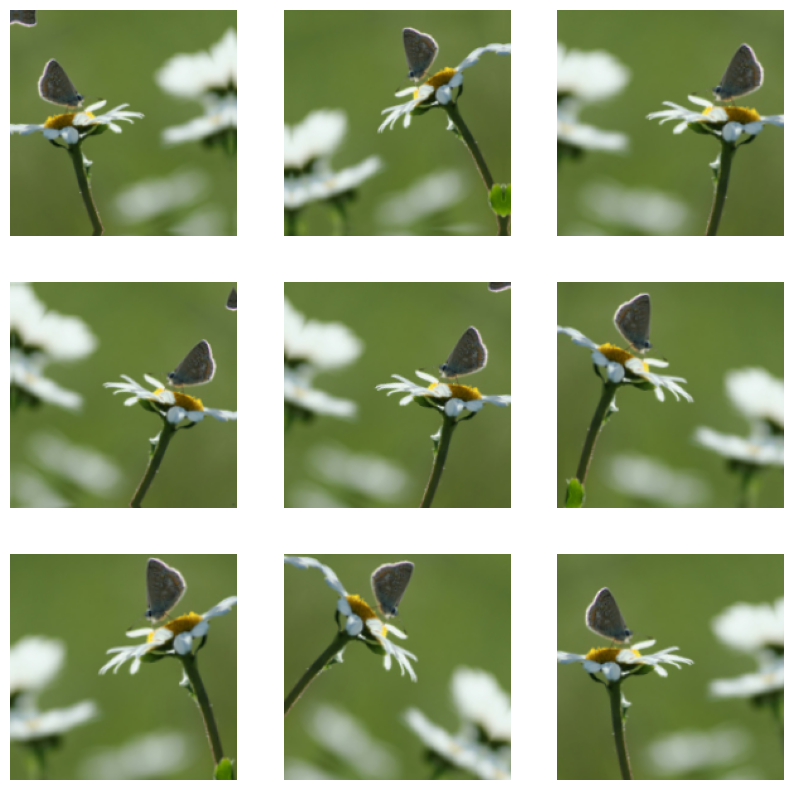

In [29]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will add data augmentation to your model before training in the next step.

DROPOUT 

Another technique to reduce overfitting is to introduce dropout{:.external} regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with tf.keras.layers.Dropout before training it using the augmented images:

In [30]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

Compile and train the model

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 316ms/step - accuracy: 0.4261 - loss: 1.3499 - val_accuracy: 0.5477 - val_loss: 1.1257
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.5722 - loss: 1.0648 - val_accuracy: 0.6240 - val_loss: 0.9740
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.6427 - loss: 0.9337 - val_accuracy: 0.6376 - val_loss: 0.9727
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - accuracy: 0.6444 - loss: 0.9136 - val_accuracy: 0.6649 - val_loss: 0.8491
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 169ms/step - accuracy: 0.6785 - loss: 0.8366 - val_accuracy: 0.6540 - val_loss: 0.8966
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - accuracy: 0.6890 - loss: 0.7967 - val_accuracy: 0.6390 - val_loss: 0.8367
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 177ms/step - accuracy: 0.7054 - loss: 0.7458 - val_accuracy: 0.6662 - val_loss: 0.8795
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 174ms/step - accuracy: 0.7360 - loss: 0.6985 - val_accu

VISULIZE AND TRAINING RESULT 

After applying data augmentation and tf.keras.layers.Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned:

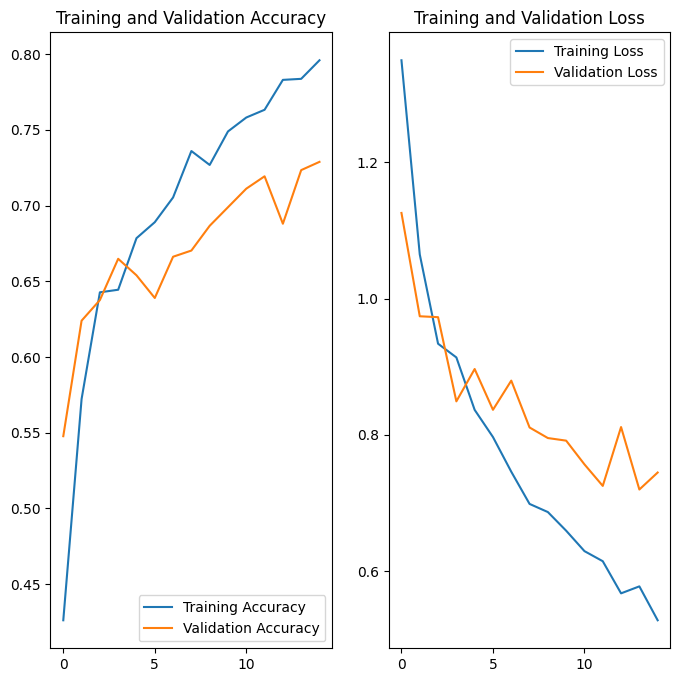

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

PREDICT ON NEW DATA 

Use your model to classify an image that wasn't included in the training or validation sets.
Note: Data augmentation and dropout layers are inactive at inference time.

In [42]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
This image most likely belongs to sunflowers with a 93.15 percent confidence.
